In [1]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 28.4 MB/s 


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm, metrics, datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2

from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download omkarmanohardalvi/lungs-disease-dataset-4-types

 99% 2.01G/2.02G [00:25<00:00, 36.7MB/s]
100% 2.02G/2.02G [00:25<00:00, 85.9MB/s]


In [ ]:
! unzip lungs-disease-dataset-4-types.zip

In [8]:
train_path = r'Lung Disease Dataset/train'
validation_path = r'Lung Disease Dataset/val'
test_path = r'Lung Disease Dataset/test'

In [9]:
training_generator = ImageDataGenerator()
validation_generator = ImageDataGenerator()
testing_generator = ImageDataGenerator()

IMG_SIZE = 224
#now we load the training data from our directory
training_dataset = training_generator.flow_from_directory(train_path,
                                                        target_size = (IMG_SIZE, IMG_SIZE),
                                                        batch_size = 64,
                                                        class_mode='categorical',
                                                        shuffle = True)

validation_dataset = validation_generator.flow_from_directory(validation_path,
                                                        target_size = (IMG_SIZE, IMG_SIZE),
                                                        batch_size = 64,
                                                        class_mode='categorical',
                                                        shuffle = True)

testing_dataset = testing_generator.flow_from_directory(test_path,
                                                        target_size = (IMG_SIZE, IMG_SIZE),
                                                        batch_size = 64,
                                                        class_mode='categorical',
                                                        shuffle = True)

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [10]:
training_dataset.class_indices

{'Bacterial Pneumonia': 0,
 'Corona Virus Disease': 1,
 'Normal': 2,
 'Tuberculosis': 3,
 'Viral Pneumonia': 4}

In [ ]:
from tensorflow.keras import mixed_precision
# use pre-train model of EfficientNetB0
tf.keras.mixed_precision.set_global_policy('mixed_float16')
base_model_b0 = tf.keras.applications.EfficientNetB0(input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# lock layers
for layer in base_model_b0.layers:
  layer.trainable = False

# set full connect layers
#x = layers.Flatten()(base_model_b0.output)  # base_model_b0.output
x = layers.GlobalAveragePooling2D()(base_model_b0.output)
x = layers.Dropout(0.5)(x) # 
x = layers.Dense(512, activation= 'relu')(x)
x = layers.Dense(512, activation= 'relu')(x)
x = layers.Dense(5, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model_b0.input, x)  # keras.models not keras.model

learningRate = 1e-2;
# compile
optimizer = tf.keras.optimizers.Nadam(learning_rate=learningRate)
optimizer = tfa.optimizers.Lookahead(optimizer, clipnorm=1)
model.compile(optimizer, loss = tf.keras.losses.CategoricalCrossentropy(),metrics = ['accuracy'])

# you can turn on summary
model.summary()

In [12]:
import math

decay_steps = 9
initial_learning_rate = learningRate
Total_Epochs = 15

def decayed_learning_rate(epoch):
  cosine_decay = 0.5 * (1 + math.cos(math.pi * epoch / decay_steps))
  return initial_learning_rate * cosine_decay

def scheduler(epoch, lr):
  if epoch < 4:
    return initial_learning_rate * 0.25 * (epoch + 1)
  elif epoch < 6:
    return initial_learning_rate
  else:
    return decayed_learning_rate(epoch-6)


In [13]:
# use checkpoint to save the best model
# use ReduceLROnPlateau to automaticly turn down learning rate
Checkpoint = tf.keras.callbacks.ModelCheckpoint("efficientnetb0.hdf5", monitor="val_accuracy", save_best_only= True, mode="max")
lr_Scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

history = model.fit(training_dataset, validation_data= validation_dataset, epochs=15, callbacks = [lr_Scheduler, Checkpoint], verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.0025.
Epoch 1/15
95/95 [==============================] - 115s 1s/step - loss: 0.7146 - accuracy: 0.7043 - val_loss: 0.4251 - val_accuracy: 0.8194 - lr: 0.0025

Epoch 2: LearningRateScheduler setting learning rate to 0.005.
Epoch 2/15
95/95 [==============================] - 95s 999ms/step - loss: 0.5459 - accuracy: 0.7755 - val_loss: 0.3996 - val_accuracy: 0.8338 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.0075.
Epoch 3/15
95/95 [==============================] - 94s 996ms/step - loss: 0.5297 - accuracy: 0.7846 - val_loss: 0.3690 - val_accuracy: 0.8423 - lr: 0.0075

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/15
95/95 [==============================] - 94s 988ms/step - loss: 0.5091 - accuracy: 0.7901 - val_loss: 0.4197 - val_accuracy: 0.8110 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/15
95/95 [==============================] - 93s 98

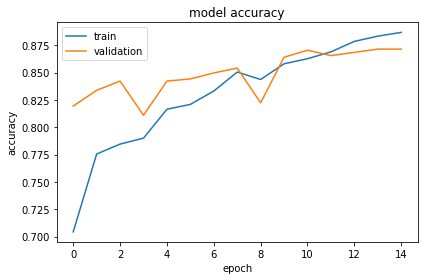

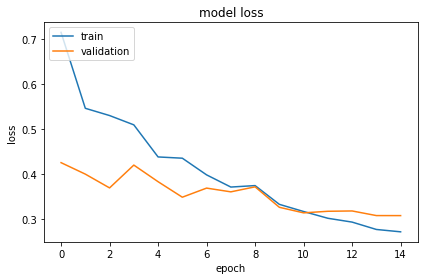

In [14]:
def plot_acc(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.tight_layout()
  plt.show()

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.tight_layout()
  plt.show()

plot_acc(history)
plot_loss(history)

In [17]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4)
    optimizer = tfa.optimizers.Lookahead(optimizer, clipnorm=1)
    model.compile(
        optimizer=optimizer, loss= tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"]
    )
 
unfreeze_model(model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# use checkpoint to save the best model
# use ReduceLROnPlateau to automaticly turn down learning rate
Checkpoint = tf.keras.callbacks.ModelCheckpoint("efficientnetb0_fine_tuned.hdf5", monitor="val_loss", save_best_only= True, mode="auto")

history = model.fit(training_dataset, validation_data= validation_dataset, epochs=10, callbacks = [Checkpoint], verbose=1)

Epoch 1/10
95/95 [==============================] - 106s 1s/step - loss: 0.2897 - accuracy: 0.8908 - val_loss: 0.3040 - val_accuracy: 0.8760
Epoch 2/10
95/95 [==============================] - 94s 993ms/step - loss: 0.2573 - accuracy: 0.8911 - val_loss: 0.2969 - val_accuracy: 0.8780
Epoch 3/10
95/95 [==============================] - 93s 984ms/step - loss: 0.2499 - accuracy: 0.8981 - val_loss: 0.2976 - val_accuracy: 0.8735
Epoch 4/10
95/95 [==============================] - 93s 983ms/step - loss: 0.2372 - accuracy: 0.9024 - val_loss: 0.3083 - val_accuracy: 0.8705
Epoch 5/10
95/95 [==============================] - 94s 987ms/step - loss: 0.2411 - accuracy: 0.8979 - val_loss: 0.2912 - val_accuracy: 0.8849
Epoch 6/10
95/95 [==============================] - 94s 987ms/step - loss: 0.2349 - accuracy: 0.9016 - val_loss: 0.2895 - val_accuracy: 0.8819
Epoch 7/10
95/95 [==============================] - 94s 990ms/step - loss: 0.2301 - accuracy: 0.9035 - val_loss: 0.2868 - val_accuracy: 0.8819
E

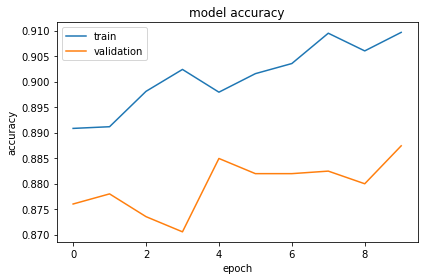

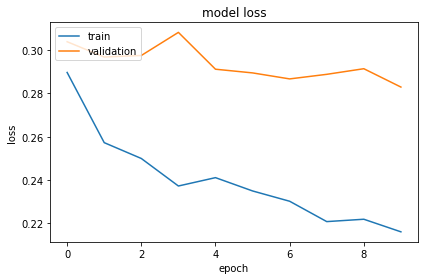

In [21]:
plot_acc(history)
plot_loss(history)

In [22]:
from tqdm import tqdm

In [23]:
testing_dataset.reset()
X_test, y_test = next(testing_dataset)
for i in tqdm(range(len(testing_dataset)-1)): #1st batch is already fetched before the for loop.
  img, label = next(testing_dataset)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

100%|██████████| 31/31 [00:33<00:00,  1.07s/it]

(2025, 224, 224, 3) (2025, 5)


In [24]:
from sklearn import svm, metrics, datasets
from sklearn.metrics import confusion_matrix, recall_score

In [25]:
result = model.evaluate(X_test,y_test)
print(result)

64/64 [==============================] - 5s 46ms/step - loss: 0.2740 - accuracy: 0.8854
[0.2740045189857483, 0.8854321241378784]


In [35]:
y_pred = np.around(model.predict(X_test))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       403
           1       0.99      0.98      0.99       407
           2       0.94      0.94      0.94       404
           3       0.99      0.99      0.99       408
           4       0.75      0.71      0.73       403

   micro avg       0.89      0.88      0.88      2025
   macro avg       0.89      0.88      0.88      2025
weighted avg       0.89      0.88      0.88      2025
 samples avg       0.88      0.88      0.88      2025



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Model Recall: what percentage of positive tuples are labelled as such?
y_pred = np.around(model.predict(X_test))
recall_average = recall_score(y_test,y_pred, average="micro")
print("Recall:",recall_average)

Recall: 0.8760493827160494


In [27]:
#Model Accuracy: how often is the classifier correct?\n
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?\n",
print("Precision:",metrics.precision_score(y_test, y_pred, average="macro"))

Accuracy: 0.8760493827160494
Precision: 0.8907600400043151


In [28]:
training_dataset.class_indices
labels=['Bacterial Pneumonia','Corona Virus Disease','Normal','Tuberculosis','Viral Pneumonia']
label_n=[0,1,2,3,4]

In [29]:
y_true=np.argmax(y_test, axis=-1)
y_final = np.argmax(y_pred, axis=-1)

In [30]:
import pandas as pd
conf_matrix = confusion_matrix(y_true, y_final)
cm_array = pd.DataFrame(conf_matrix, index=labels, columns=labels)

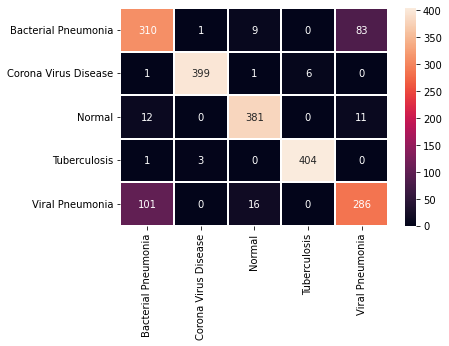

In [31]:
import seaborn as sns
sns.heatmap(cm_array, linewidths=1, annot=True, fmt='g')

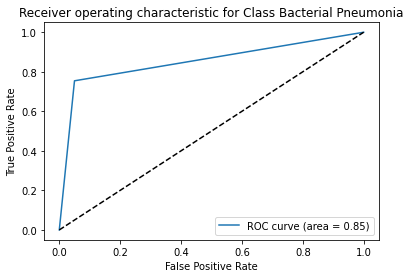

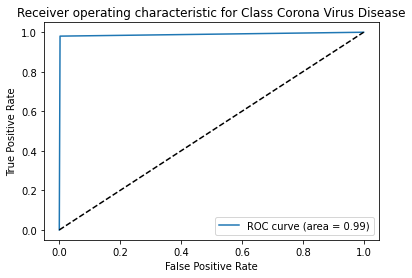

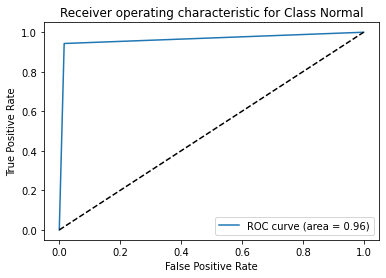

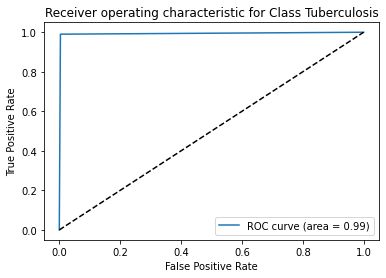

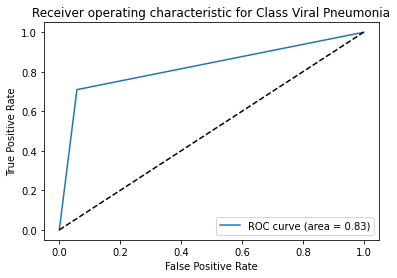

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = ["Bacterial Pneumonia","Corona Virus Disease","Normal","Tuberculosis","Viral Pneumonia"]
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(5):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic for Class {class_names[i]}')
    plt.legend(loc="lower right")
    plt.show()
    print("\n")

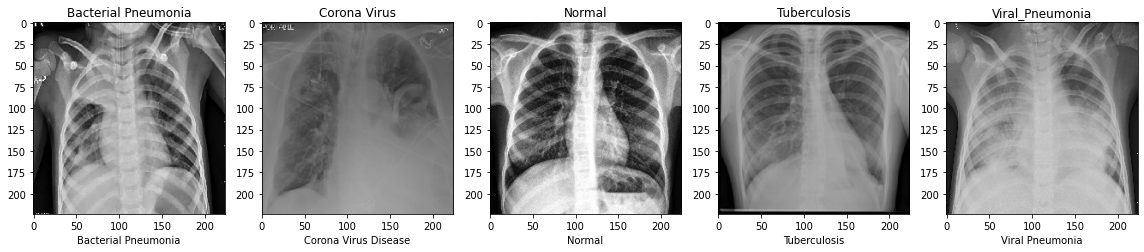

In [34]:
from keras.preprocessing import image
Bacterial_Pneumonia = image.load_img("/content/Lung Disease Dataset/test/Bacterial Pneumonia/174.jpeg",target_size = (IMG_SIZE,IMG_SIZE))
Bacterial_Pneumonia  = np.array(Bacterial_Pneumonia )

Corona_virus = image.load_img("/content/Lung Disease Dataset/test/Corona Virus Disease/00030410_007.png",target_size = (IMG_SIZE,IMG_SIZE))
Corona_virus = np.array(Corona_virus)

Normal = image.load_img("/content/Lung Disease Dataset/test/Normal/024.jpeg",target_size = (IMG_SIZE,IMG_SIZE))
Normal = np.array(Normal)

Tuberculosis = image.load_img("/content/Lung Disease Dataset/test/Tuberculosis/Tuberculosis-163.jpg",target_size = (IMG_SIZE,IMG_SIZE))
Tuberculosis = np.array(Tuberculosis)

Viral_Pneumonia = image.load_img("/content/Lung Disease Dataset/test/Viral Pneumonia/VIRUS-1335423-0007.jpeg",target_size = (IMG_SIZE,IMG_SIZE))
Viral_Pneumonia = np.array(Viral_Pneumonia)

fig, axes = plt.subplots(1, 5, figsize=(16, 8))
ax = axes.ravel()

X_sample = [Bacterial_Pneumonia,Corona_virus,Normal,Tuberculosis,Viral_Pneumonia]
X_sample = np.asarray(X_sample)

y_predict = np.around(model.predict(X_sample))
y_predict = np.argmax(y_predict, axis=-1)

ax[0].imshow(Bacterial_Pneumonia, cmap=plt.cm.gray)
ax[0].set_title("Bacterial Pneumonia")
ax[0].set_xlabel(labels[y_predict[0]])


ax[1].imshow(Corona_virus, cmap=plt.cm.gray)
ax[1].set_title("Corona Virus")
ax[1].set_xlabel(labels[y_predict[1]])

ax[2].imshow(Normal, cmap=plt.cm.gray)
ax[2].set_title("Normal")
ax[2].set_xlabel(labels[y_predict[2]])

ax[3].imshow(Tuberculosis, cmap=plt.cm.gray)
ax[3].set_title("Tuberculosis")
ax[3].set_xlabel(labels[y_predict[3]])

ax[4].imshow(Viral_Pneumonia, cmap=plt.cm.gray)
ax[4].set_title("Viral_Pneumonia")
ax[4].set_xlabel(labels[y_predict[4]])

fig.tight_layout()
plt.show()